In [36]:
import csv
import numpy as np
import random
import matplotlib.pyplot as plt

### First we will initialize lists for each of our Data types

RestaurantIDs = []
Latitudes = []
Longitudes = []
Cuisines = []
Average_Cost = []
Minimum_Order = []
Rating = []
Votes = []
Reviews = []
Cook_Time = []

### Next, we need to import our data set

csv_file = open('C:/Users/jerem/OneDrive/2020-XTern-DS.csv')

XTernData = csv.reader(csv_file, delimiter = ',')

next(XTernData)

for row in XTernData:
    
    for i in range(0, 10):
        
        if i == 0:
            
            RestaurantIDs.append(str(row[i]))
        
        elif i == 1:
            
            Latitudes.append(float(row[i]))
        
        elif i == 2:
        
            Longitudes.append(float(row[i]))
        
        elif i == 3:
        
            Cuisines.append(row[i].split(','))  ## each element is a list of each restaurant's cuisines
        
        elif i == 4:
        
            avg_cost = row[i][1:]           ## removes $ from each entry (first character)
            
            Average_Cost.append(float(avg_cost))
        
        elif i == 5:
            
            min_order = row[i][1:-1]        ## removes '$' from beginning and ' ' from end of each entry (first and last characters)
        
            Minimum_Order.append(float(min_order))
        
        elif i == 6:
        
            Rating.append(row[i])
        
        elif i == 7:
        
            if row[i] == '-':           ## assume '-' means no votes
            
                Votes.append(int(0))
            
            else:
            
                Votes.append(int(row[i]))
        
        elif i == 8:
        
            if row[i] == '-':           ## assume '-' means no reviews
            
                Reviews.append(0)
            
            else:
            
                Reviews.append(int(row[i]))
        
        elif i == 9:
            
            cooktime = row[i][:-8]          ## removes ' minutes' from each entry (last 8 characters)
        
            Cook_Time.append(int(cooktime))
            
### NOTE: Some of the data was formatted incorrectly. For interest of time, I let
### the program tell me which entries were incorrect, and manually revised them
### in the original data set.
            
csv_file.close()

def check_float(potential_float): ## determines if a string can be converted to a float
    try:
        float(potential_float)
        
        return True
    
    except ValueError:
        
        return False
    
    
            
def genListOfWeights(latitude, longitude, avgCost, minOrder, cookTime, rating):
    
    ## this method involves using inverse square matrices to determine the "weight" of
    ## each variable in determinig the rating of each restaurant. This function takes
    ## Latitude, Longitude, average cost, minimum order, and cook time
    ## into account. The function randomly selects, without replacement,
    ## 5 restaurants that have a rating, and populate a 5x5 square matrix where each row
    ## contains each restaurant's data. Since this is a square matrix, if there exists an
    ## inverse of this matrix, we can multiply it to a "vector" where each row contains the
    ## rating of each restaurant. Doing this will produce a vector whose components represent
    ## the weight of each coefficient in the system. This function generates 10,000 solutions.
    ## Later, we will test these solutions on the entire set of data to determine the best
    ## set of weights.
    
    
    list_of_weights = []
    
    k = 0
    
    while k < 10000:
        
        restaurant1 = []
        restaurant2 = []
        restaurant3 = []
        restaurant4 = []
        restaurant5 = []
    
        ratings = []
    
        usedIndexes = []        ## keeps track of used indexes so that we can sample without replacement
    
        i = 0
    
        while i < 5:
            j = random.randint(0,2018)
            if j not in usedIndexes:                    ## determines if we have used index j so we can sample without replacement
                if check_float(rating[j]) == True:      ## determines if the rating at index j can be converted to a float (Meaning the rating is provided)
                    ratings.append(float(rating[j]))
                    i += 1          ## increments i if we have chosen a suitable j
                
                    if i == 1:
                        restaurant1.extend([latitude[j], longitude[j], avgCost[j], minOrder[j], cookTime[j]])
                    
                    elif i == 2:
                        restaurant2.extend([latitude[j], longitude[j], avgCost[j], minOrder[j], cookTime[j]])
                
                    elif i == 3:
                        restaurant3.extend([latitude[j], longitude[j], avgCost[j], minOrder[j], cookTime[j]])
                
                    elif i == 4:
                        restaurant4.extend([latitude[j], longitude[j], avgCost[j], minOrder[j], cookTime[j]])
                        
                    elif i == 5:
                        restaurant5.extend([latitude[j], longitude[j], avgCost[j], minOrder[j], cookTime[j]])
                
                    
        restaurantDataMatrix = np.array([restaurant1,       ## populates a matrix with five rows of restaurant data
                                         restaurant2,
                                         restaurant3,
                                         restaurant4,
                                         restaurant5])
    
        if np.linalg.det(restaurantDataMatrix) != 0:        ## determines if our matrix can be inverted (a matrix as an inverse if and only if its determinant is nonzero)
            
            k += 1          ## k increments if we find an invertible matrix                                          
        
            invertedDataMatrix = np.linalg.inv(restaurantDataMatrix)        ## inverts matrix
        
            ratingsArray = np.array([ratings[0],            ## populated with the ratings of each selected restaurant
                                     ratings[1],
                                     ratings[2],
                                     ratings[3],
                                     ratings[4]])
    
            weights = invertedDataMatrix.dot(ratingsArray)          ## multiplies our inverted matrix by our ratings "vector"
        
            list_of_weights.append(weights)     ## adds solution to list of weights
            
    return list_of_weights
            
weightsToBeTested = genListOfWeights(Latitudes, Longitudes, Average_Cost, Minimum_Order, Cook_Time, Rating)   
    


def chooseWeights(latitude, longitude, avgCost, minOrder, cookTime, rating, setOfWeights):
    
    ## This function tests all of the generated sets of weights by applying
    ## them to the data of every restaurant that has a known rating. For every
    ## set of weights, we calculate the estimated ratings of every applicable 
    ## restaurant and calculate the average ammount of error between each actual 
    ## rating and the estimated rating. This average error is compared to the the
    ## average error obtained by the next set of weights. Whichever set produces
    ## the error closest to 0 has its index saved, and its error becomes the new
    ## standard to compare to.
    
    bestEstimation = 1000000000000          ## bestEstimation initialized at a large enough number to ensure the first estimation is better
    
    indexOfBestWeights = 0
    
    for i in range(0, 10000):                ## tests all 10000 sets of weights
        actualRatings = []                  ## when the set of weights is changed, we depopulate both lists
        estimatedRatings = []
        
        for j in range(0, 2019):            ## tests all 2019 restaurants
            if check_float(rating[j]) == True:          ## determines if a restaurant has a known rating. If so, calculations proceed
                actualRatings.append(float(rating[j]))
                ratingEstimate = latitude[j] * setOfWeights[i][0] + longitude[j] * setOfWeights[i][1] + avgCost[j] * setOfWeights[i][2] + minOrder[j] * setOfWeights[i][3] + cookTime[j] * setOfWeights[i][4]
                estimatedRatings.append(ratingEstimate)
                
        avgErrorOfEstimation = abs((sum(estimatedRatings) - sum(actualRatings)) / j)
        
        if avgErrorOfEstimation < bestEstimation:
            
            bestEstimation = avgErrorOfEstimation
            
            indexOfBestWeights = i
        
    
    return list(setOfWeights[indexOfBestWeights])       ## returns set of weights that produced the smallest error


chosenWeights = chooseWeights(Latitudes, Longitudes, Average_Cost, Minimum_Order, Cook_Time, Rating, weightsToBeTested)
            
            
                
def estimateRatings(latitude, longitude, avgCost, minOrder, cookTime, rating, setOfWeights):
    
    ## This function estimates the ratings for any restaurant that was not provided
    ## one in the data set. It takes the four previously used variables and calculates
    ## an estimate based on the set of weights that previously produced the smallest
    ## error.
    
    RatingsWithEstimates = []

    for i in range(0, 2019):
        if check_float(rating[i]) == True:          ## checks if the rating is provided. If so, we convert it from a string to a float and append it to the list
            RatingsWithEstimates.append(float(rating[i]))
        else:                                       ## if a rating is not provied, we estimate it
            RatingsWithEstimates.append(round(latitude[i] * setOfWeights[0] + longitude[i] * setOfWeights[1] + avgCost[i] * setOfWeights[2] + minOrder[i] * setOfWeights[3] + cookTime[i] * setOfWeights[4], 1))
                
    return RatingsWithEstimates
    
Rating = estimateRatings(Latitudes, Longitudes, Average_Cost, Minimum_Order, Cook_Time, Rating, chosenWeights)

### Our Rating list now contains rating estimates for restaurants that previously had
### no provided rating in the data set


Text(0.5, 1.0, 'Restaurant Locations')

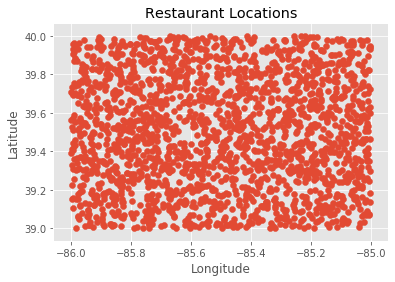

In [37]:
### the following scatter plot shows the distribution of all of the restaurants

plt.style.use('ggplot')
plt.scatter(Longitudes, Latitudes)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Restaurant Locations')

Text(0.5, 1.0, 'Locations and Ratings of Restaurants')

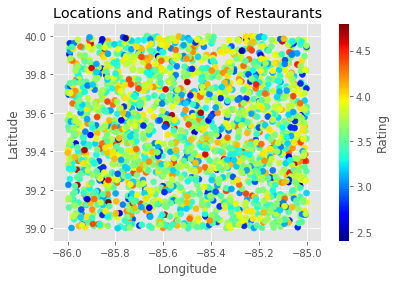

In [38]:
### Using the following colored scatter plot, we can visualize where the highest 
### rated restaurants are located

points = plt.scatter(Longitudes, Latitudes, c = Rating, cmap = "jet")
plt.colorbar(points, label = 'Rating')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Locations and Ratings of Restaurants')

In [39]:
### By studying our weights, we can confirm how much Latitude and Longitude
### affect the rating of a restaurant

print('Latitude Weight: ' + str(chosenWeights[0]))
print('Longitude Weight : ' + str(chosenWeights[1]))

Latitude Weight: 0.43112190416119267
Longitude Weight : 0.15180123704956716


Text(0.5, 1.0, 'Frequency of Ratings for Restaurants in the Area')

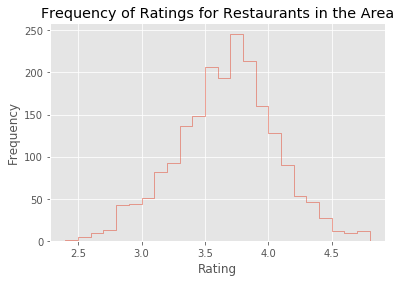

In [40]:
### This means that on average, as latitude and longitude increase by 1, a restaurant's
### rating increases by about 0.583. Therefore, we expect to find higher rated 
### restaurants farther Northeast than lower rated restaurants

### The following histogram displays the relative frequency for each rating

plt.hist(Rating, bins = int((max(Rating) - min(Rating)) * 10), histtype = 'step')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Frequency of Ratings for Restaurants in the Area')

In [41]:
### By looking at this histogram, we see that the distribution of restaurant
### ratings is approximately normal, is centered about 3.6, ranges from 2.4
### to 4.8, and contains no outliers.

### Next, we can score each restaurant based on the z-score of its rating,
### number of votes, and number of reviews to determine the trending restaurants
### in the area

def Trending (ratings, votes, reviews):
    
    trendScores = []
    
    meanRating = np.mean(ratings)
    sdRating = np.std(ratings)
    
    for i in range (0, 2019):
        score = ((ratings[i] - meanRating) / sdRating) * votes[i] * reviews[i]
        trendScores.append(score)
        
    return trendScores

trendingScores = Trending(Rating, Votes, Reviews)

highestTrendingIndex = trendingScores.index(max(trendingScores))

print('The highest trending restaurant is ' + str(RestaurantIDs[highestTrendingIndex]) + '. It has ' + str(Rating[highestTrendingIndex]) + ' stars, ' + str(Votes[highestTrendingIndex]) + ' votes, and ' + str(Reviews[highestTrendingIndex]) + ' reviews.')

The highest trending restaurant is ID_1064. It has 4.7 stars, 9054 votes, and 6504 reviews.


In [42]:
############################## FINDINGS #############################



### 1. Prediction of ratings for unrated restaurants

### First, I developed an algorithm that applies properties of square matrices
### to predict the ratings of restaurants that were not provided one in the data
### set. To do this, I randomly selected 5 restaurants with known ratings without
### replacement and populated a 5x5 square matrix where each row comrpised of the
### latitude, longitude, average cost, minimum order, and cook time of each restaurant.
### If this matrix had a nonzero determinant, I inverted the matrix and multiplied
### it to an array representing a 1x5 vector that contained the rating of each
### restaurant as its entries. This produced a set of weights for each variable.
### I repeated this process 10,000 times, then compared each set of weights to
### to each other by applying them to the entire data set and determining
### the set that produced the lowest error. This set of weights was then used to 
### predict the ratings for unrated restaurants.

### 2. Restaurants tend to be rated higher the farther Northeast it is 

### Next, I created a colored scatter plot to show where the highest rated
### restaurants were located. I found that the highest rated restaurants are
### expected to be located closer to the Northeast corner, and as we travel farther
### Southwest, the ratings tend to become lower. A restaurant located at (-85, 40)
### is expected to have a rating 0.583 higher than a restaurant located at (-86, 39).

### 3. Normality of ratings distribution

### Next, I created a histogram that plotted the frequency of each rating (including
### the predicted ratings from our first rating) in the data set, and discovered
### that the distribution of ratings for our restaurants was approximately normal,
### centered around 3.6, between 2.4 and 4.8, and contained no outliers. This means
### that if we wnated to, our team could perform normal calculations on the distribution
### of restaurant ratings.

### 4. Determination of highest trending restaurants

### Finally, I developed a scoring system that multiplies the z-score of each 
### restaurant's rating by its number of votes and reviews to determine the
### highest trending restaurants in the area.          